# Data Preparation & Feature Selection Project with Healthcare Data
## Jeff Laurel

**This project uses Python to demonstrate the steps for cleaning a large dataset with multiple variables and data types, and how to select the approrpriate features that contribute to a specific outcome.**  

**The outcome for this example is patient length of stay (LOS). The dataset contains about 32,000 patients with multiple
factors such as patient details, demography, medical history, vitals, and diagnoses. This
data is fictitious, but represents true clinical outcomes and values.**

### Import the necessary packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle

### Import the dataset and store in a dataframe object.

In [2]:
los = pd.read_csv('LOS_Dataset.csv')

### Check the dataframe shape.

In [3]:
los.shape

(32000, 221)

### Check for duplicate rows.

In [4]:
los.duplicated().sum()

8790

### Drop the duplicate rows.

In [5]:
# Drop duplicates.
los.drop_duplicates(inplace=True)

### Recheck shape.

In [6]:
los.shape

(23210, 221)

### Check for Missing Values.

In [7]:
# Set display option to allow for up to 500 rows in output.
pd.set_option('display.max_rows', 500)
los.isnull().sum()

encounterID                                          0
age                                                  0
edVisitCountPast3months                              0
admissionMonth                                       0
admissionBetweenThuAndSat                            0
edTimeBeforeAdmission                             9420
firstTemperatureReadingInED                      19806
meanLOSPast24months                              18765
inpatientAdmitCountPast3months                       0
meanTemperaturePast12months                      22731
inpatientAdmitCountPast6months                       0
inpatientAdmitCountPast12months                      0
hospitalAdmitCountPast3months                        0
hospitalAdmitCountPast6months                        0
edVisitCountPast6months                              0
medianTemperaturePast12months                    22731
meanHeartRatePast12months                        19690
isFirstTemperatureInEDLess34OrGreater38          19804
firstHeart

### Assess the percentage of missing values for each variable.

In [8]:
los.isnull().sum()/len(los) * 100

encounterID                                        0.000000
age                                                0.000000
edVisitCountPast3months                            0.000000
admissionMonth                                     0.000000
admissionBetweenThuAndSat                          0.000000
edTimeBeforeAdmission                             40.585954
firstTemperatureReadingInED                       85.333908
meanLOSPast24months                               80.848772
inpatientAdmitCountPast3months                     0.000000
meanTemperaturePast12months                       97.936234
inpatientAdmitCountPast6months                     0.000000
inpatientAdmitCountPast12months                    0.000000
hospitalAdmitCountPast3months                      0.000000
hospitalAdmitCountPast6months                      0.000000
edVisitCountPast6months                            0.000000
medianTemperaturePast12months                     97.936234
meanHeartRatePast12months               

**Checking for missing values and assessing the percentage of each dataframe column reveals a significant number of rows with missing values.  
It does not make sense to impute these values due to the widespread variability in the percentage of missing values.  
The columns with only small percentages of missing values are not appropriate for imputation either, since these values need to be accurate.  
For this project, columns with any missing values will be dropped from the dataframe.**

### Drop columns from dataframe.

In [9]:
los.dropna(how = 'any', axis=1,inplace=True)

### Review resulting dataframe and the datatypes for the variables.

In [10]:
los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23210 entries, 0 to 31999
Data columns (total 49 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   encounterID                                  23210 non-null  int64  
 1   age                                          23210 non-null  int64  
 2   edVisitCountPast3months                      23210 non-null  int64  
 3   admissionMonth                               23210 non-null  int64  
 4   admissionBetweenThuAndSat                    23210 non-null  bool   
 5   inpatientAdmitCountPast3months               23210 non-null  int64  
 6   inpatientAdmitCountPast6months               23210 non-null  int64  
 7   inpatientAdmitCountPast12months              23210 non-null  int64  
 8   hospitalAdmitCountPast3months                23210 non-null  int64  
 9   hospitalAdmitCountPast6months                23210 non-null  int64  
 10

### Deal with categorical and unnecessary variables.

**The Boolean variables need to be converted to numeric 1/0 values.  
The Charlson Comorbidity Index variable is actually a categorical variable and its values needs to be One Hot Encoded.  
The encounter ID variable is unnecessary for determining the output variable and can be removed.**

### Drop the encounter ID column.

In [11]:
los.drop('encounterID', axis=1, inplace=True)

### Convert the boolean variables to numeric data.

In [12]:
los.replace({True:1, False:0}, inplace=True)

### Review changes.

In [13]:
los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23210 entries, 0 to 31999
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   age                                          23210 non-null  int64  
 1   edVisitCountPast3months                      23210 non-null  int64  
 2   admissionMonth                               23210 non-null  int64  
 3   admissionBetweenThuAndSat                    23210 non-null  int64  
 4   inpatientAdmitCountPast3months               23210 non-null  int64  
 5   inpatientAdmitCountPast6months               23210 non-null  int64  
 6   inpatientAdmitCountPast12months              23210 non-null  int64  
 7   hospitalAdmitCountPast3months                23210 non-null  int64  
 8   hospitalAdmitCountPast6months                23210 non-null  int64  
 9   edVisitCountPast6months                      23210 non-null  int64  
 10

### Check for outliers.

In [14]:
# Create a variable for investigating outliers.

outlier_investigation = los.describe()

In [15]:
# Create a list for the continuous numeric variables.

outlier_columns = ['age','edVisitCountPast3months', 'inpatientAdmitCountPast3months', 'inpatientAdmitCountPast6months',
                   'inpatientAdmitCountPast12months','hospitalAdmitCountPast3months', 'hospitalAdmitCountPast6months',
                  'hospitalAdmitCountPast12months', 'edVisitCountPast12months', 'daysSinceLastInpatientEncounter',
                  'actualLOS', 'chronicConditionCount', 'proceduresCount']

In [16]:
# Use a for loop to determine the columns with outliers using the Boxplot method.

for column in outlier_columns:
    
    lower_quartile = los[column].quantile(0.25)
    upper_quartile = los[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2 # So not to cut too many.
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = los[(los[column] < min_border) | (los[column] > max_border)].index
    print(f'{len(outliers)} outliers detected in column {column}.')

0 outliers detected in column age.
1989 outliers detected in column edVisitCountPast3months.
263 outliers detected in column inpatientAdmitCountPast3months.
384 outliers detected in column inpatientAdmitCountPast6months.
514 outliers detected in column inpatientAdmitCountPast12months.
2224 outliers detected in column hospitalAdmitCountPast3months.
2970 outliers detected in column hospitalAdmitCountPast6months.
3718 outliers detected in column hospitalAdmitCountPast12months.
3338 outliers detected in column edVisitCountPast12months.
1060 outliers detected in column daysSinceLastInpatientEncounter.
1623 outliers detected in column actualLOS.
82 outliers detected in column chronicConditionCount.
242 outliers detected in column proceduresCount.


**For each of the inputs with outliers, the total number represents a small percentage.  
However, since these are all variables that contribute clinically to a patient's length of stay, the outliers are kept.   
These are addressed in the Feature Selection section below.**



### Shuflle the data.

In [19]:
# Shuffle the dataframe.
los = shuffle(los, random_state = 42)

### Perform One Hot Encoding.

In [20]:
# Convert numeric columns that are actually categorical data.
los['charlsonComorbidityIndex'] = los['charlsonComorbidityIndex'].astype('category')
los['admissionMonth'] = los['admissionMonth'].astype('category')


#Confirm conversion.
los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23210 entries, 14342 to 19216
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   age                                          23210 non-null  int64   
 1   edVisitCountPast3months                      23210 non-null  int64   
 2   admissionMonth                               23210 non-null  category
 3   admissionBetweenThuAndSat                    23210 non-null  int64   
 4   inpatientAdmitCountPast3months               23210 non-null  int64   
 5   inpatientAdmitCountPast6months               23210 non-null  int64   
 6   inpatientAdmitCountPast12months              23210 non-null  int64   
 7   hospitalAdmitCountPast3months                23210 non-null  int64   
 8   hospitalAdmitCountPast6months                23210 non-null  int64   
 9   edVisitCountPast6months                      23210 non-nu

In [21]:
# Create a list for the categorical variables.

cat_vars = ['admissionMonth', 'charlsonComorbidityIndex']

In [22]:
# Instantiate the One-Hot Encoder.
# Set sparse=False to returns an array and not a sparse matrix.
# Set drop='first' to always remove one of the one-hot encdoed columns so that multicollinearity is not violated.

one_hot_encoder = OneHotEncoder(sparse=False, drop='first') 

In [23]:
# Fit and transform the dataframe columns for one-hot-encoding. 

cat_array = one_hot_encoder.fit_transform(los[cat_vars])

C:\Users\travj\anaconda3\envs\DSI\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
# Use the get feature names method to return the names of the columns that were encoded.

encoder_feature_names = one_hot_encoder.get_feature_names_out(cat_vars)

### Construct cleaned dataframe.

In [25]:
# Put the encoded feature names back into a dataframe.

encoder_vars_df = pd.DataFrame(cat_array, columns=encoder_feature_names)

In [26]:
# Concatenate with the original dataframe.
# Set reset_index drop parameter to True to ensure that all values line up.
# Set axis=1 so that columns, and not rows, are affected.

los_new = pd.concat([los.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis=1)

In [27]:
# Drop the original categorical variable columns because these are not needed.
# Use axis=1 to affect columns and inplace=True to apply the changes to the dataframe.

los_new.drop(cat_vars, axis=1, inplace=True)

In [28]:
# Review new dataframe columns and datatypes.

los_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23210 entries, 0 to 23209
Data columns (total 61 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   age                                          23210 non-null  int64  
 1   edVisitCountPast3months                      23210 non-null  int64  
 2   admissionBetweenThuAndSat                    23210 non-null  int64  
 3   inpatientAdmitCountPast3months               23210 non-null  int64  
 4   inpatientAdmitCountPast6months               23210 non-null  int64  
 5   inpatientAdmitCountPast12months              23210 non-null  int64  
 6   hospitalAdmitCountPast3months                23210 non-null  int64  
 7   hospitalAdmitCountPast6months                23210 non-null  int64  
 8   edVisitCountPast6months                      23210 non-null  int64  
 9   hospitalAdmitCountPast12months               23210 non-null  int64  
 10

### Perform Feature Scaling.  
**Normalization is the method chosen given the number of other 1/0 values in most other columns.**

In [29]:
# Instantiate the scaler object.
scaler = MinMaxScaler()

In [30]:
# Fit and transform the data.
scaler.fit_transform(los_new)

array([[0.73333333, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.09333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92      , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.94666667, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.48      , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76      , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [31]:
# Create normalized dataframe.
los_norm = pd.DataFrame(scaler.fit_transform(los_new), columns = los_new.columns)

In [32]:
# Review the first ten rows of the normalized dataframe.
los_norm.head(10)

,age,edVisitCountPast3months,admissionBetweenThuAndSat,inpatientAdmitCountPast3months,inpatientAdmitCountPast6months,inpatientAdmitCountPast12months,hospitalAdmitCountPast3months,hospitalAdmitCountPast6months,edVisitCountPast6months,hospitalAdmitCountPast12months,...,admissionMonth_7,admissionMonth_8,admissionMonth_9,admissionMonth_10,admissionMonth_11,admissionMonth_12,charlsonComorbidityIndex_1,charlsonComorbidityIndex_2,charlsonComorbidityIndex_3,charlsonComorbidityIndex_4
0,0.733333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.093333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.920000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.946667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.840000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,0.653333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.600000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Perform Feature Selection.  
**From leaving in the outlier values within the data, Random Forest Regression is chosen  as the model for performing feature selection,  
since Random Forests are less sensitive to outliers.** 

In [33]:
# Create variables for inputs and outputs.
X = los_norm.drop(['actualLOS'], axis=1)  
y = los_norm['actualLOS']

In [34]:
# Instantiate the Random Forest regressor and selector objects.
regressor = RandomForestRegressor(max_depth = 5, random_state = 42)
feature_selector = RFECV(regressor)  # This tells the selector the type of model to use.
                                     # The default # of folds is 5 for k-fold cross-validtion.

In [35]:
# Fit the variables.
fit = feature_selector.fit(X,y)

In [36]:
# Identify the optimal number of feature variables.
optimal_feature_count = feature_selector.n_features_

In [37]:
print(f'The optimal feature count is {optimal_feature_count}')

The optimal feature count is 13


In [38]:
# Identify which features the regressor object chose.

X_selected = X.loc[:,feature_selector.get_support()]
X_selected.head() # Review the columns the selector chose.

,age,hospitalAdmitCountPast3months,hospitalAdmitCountPast12months,daysSinceLastInpatientEncounter,chronicConditionCount,isChronicConditionAcuteMyocardialInfarction,isChronicConditionAnemia,isChronicConditionAsthma,isChronicConditionHeartFailure,isChronicConditionIschemicHeartDisease,isadmitSourceEMD,isadmitSourceMP,proceduresCount
0,0.733333,0.0,0.043478,0.215973,0.466667,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.142857
1,0.093333,0.0,0.000000,0.000000,0.066667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.057143
2,0.920000,0.0,0.000000,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3,0.946667,0.0,0.000000,0.000000,0.400000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.028571
4,0.066667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000


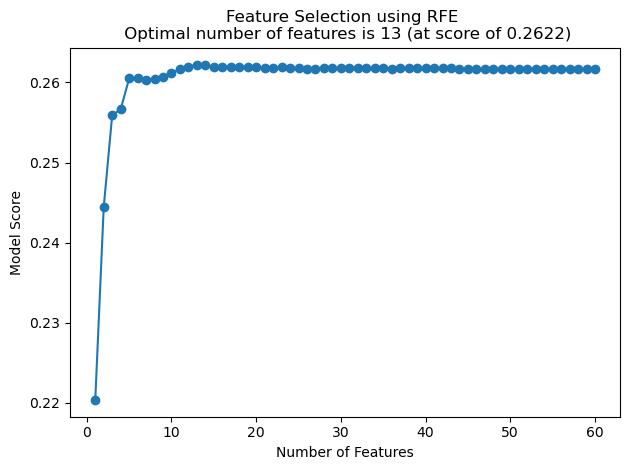

In [39]:
# Plot the results for the selector.

plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")

# + 1 above is for starting the number of feature variables at 1, not 0 (default).
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()


In [51]:
# Store the selected features in a dataframe.

features_kept = pd.DataFrame({'features': X.columns,
                             'kept': feature_selector.support_,
                             'rank': feature_selector.ranking_})

In [52]:
# Store the cross-validation results in a dataframe.

cv_results = pd.DataFrame(fit.cv_results_)

In [53]:
# Store the CV mean mean test score in a Series object.

cv_results_mean_test_score = cv_results.iloc[:,0]

In [54]:
# Add the mean CV test score to the selected features dataframe.

features_kept = features_kept.assign(mean_cv_test_score = cv_results_mean_test_score)

In [55]:
# Filter the selected features dataframe to just the selected features and store in a new dataframe.

features_kept_true = pd.DataFrame(features_kept[features_kept['kept']==True])

In [56]:
# Sort the dataframe by descending mean CV test score. Drop unnecessary columns.

features_kept_true = features_kept_true.drop(['rank', 'kept'], axis=1).sort_values(by =['mean_cv_test_score'], ascending = False)

In [57]:
# Reset the index.
features_kept_true = features_kept_true.reset_index(drop = True)

In [58]:
# Review the sorted dataframe.
features_kept_true

,features,mean_cv_test_score
0,chronicConditionCount,0.262242
1,isChronicConditionAcuteMyocardialInfarction,0.261991
2,isChronicConditionAsthma,0.261975
3,isChronicConditionAnemia,0.261974
4,daysSinceLastInpatientEncounter,0.261958
5,isadmitSourceMP,0.261797
6,isChronicConditionIschemicHeartDisease,0.261778
7,isChronicConditionHeartFailure,0.261776
8,isadmitSourceEMD,0.261749
9,proceduresCount,0.261700
